(fkm-nb)=
# Three-dimensional Fu-Kane-Mele model

:::{seealso}
Fu, Kane and Mele, PRL 98, 106803 (2007)
:::

In [1]:
from pythtb import TBModel, WFArray, Mesh
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def set_model(t, dt, soc):

  # set up Fu-Kane-Mele model
  lat = [[0, 1/2, 1/2], [1/2, 0, 1/2],[1/2, 1/2, 0]]
  orb = [[0, 0, 0],[1/4, 1/4, 1/4]]
  model = TBModel(dim_k=3, dim_r=3, lat=lat, orb=orb, nspin=2)

  # spin-independent first-neighbor hops
  for lvec in ([0,0,0],[-1,0,0],[0,-1,0],[0,0,-1]):
    model.set_hop(t,0,1,lvec)
  model.set_hop(dt,0,1,[0,0,0],mode="add")

  # spin-dependent second-neighbor hops
  lvec_list=([1,0,0],[0,1,0],[0,0,1],[-1,1,0],[0,-1,1],[1,0,-1])
  dir_list=([0,1,-1],[-1,0,1],[1,-1,0],[1,1,0],[0,1,1],[1,0,1])
  for j in range(6):
    spin=np.array([0.]+dir_list[j])
    model.set_hop( 1.j*soc*spin,0,0,lvec_list[j])
    model.set_hop(-1.j*soc*spin,1,1,lvec_list[j])

  return model

In [3]:
t = 1.0      # spin-independent first-neighbor hop
dt = 0.4     # modification to t for (111) bond
soc= 0.125  # spin-dependent second-neighbor hop

my_model = set_model(t,dt,soc)
print(my_model)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 3
k-space dimension           = 3
number of spin components   = 2
periodic directions         = [0, 1, 2]
number of orbitals          = 2
number of electronic states = 4

Lattice vectors (Cartesian):
  # 0 ===> [   0   ,  0.500 ,  0.500 ]
  # 1 ===> [ 0.500 ,    0   ,  0.500 ]
  # 2 ===> [ 0.500 ,  0.500 ,    0   ]
Orbital vectors (dimensionless):
  # 0 ===> [   0   ,    0   ,    0   ]
  # 1 ===> [ 0.250 ,  0.250 ,  0.250 ]
Site energies:
  # 0 ===> [[0.+0.j 0.+0.j]  [0.+0.j 0.+0.j]]
  # 1 ===> [[0.+0.j 0.+0.j]  [0.+0.j 0.+0.j]]
Hoppings:
  < 0 | H | 1 + [ 0.0 ,  0.0 ,  0.0 ] >  ===> [[1.4+0.j 0. +0.j]  [0. +0.j 1.4+0.j]]
  < 0 | H | 1 + [-1.0 ,  0.0 ,  0.0 ] >  ===> [[1.+0.j 0.+0.j]  [0.+0.j 1.+0.j]]
  < 0 | H | 1 + [ 0.0 , -1.0 ,  0.0 ] >  ===> [[1.+0.j 0.+0.j]  [0.+0.j 1.+0.j]]
  < 0 | H | 1 + [ 0.0 ,  0.0 , -1.0 ] >  ===> [[1.+0.j 

## Band structure

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='Energy $E(\\mathbf{{k}})$'>)

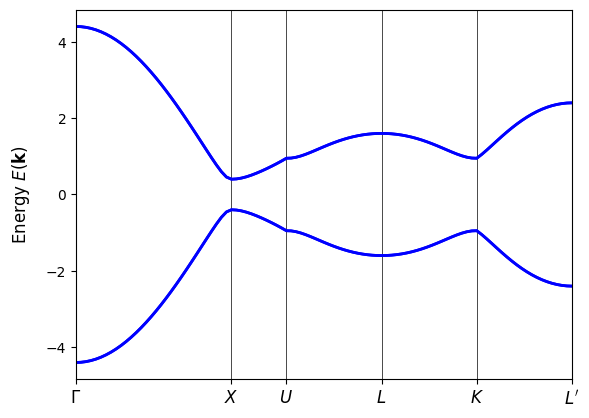

In [4]:
nodes = [
    [0,0,0], [0, 1/2, 1/2], [1/4, 5/8, 5/8],
    [1/2, 1/2, 1/2],[3/4, 3/8, 3/8],[1/2, 0, 0]
    ]
label = (r'$\Gamma$',r'$X$',r'$U$',r'$L$',r'$K$',r'$L^\prime$')
my_model.plot_bands(k_path=nodes, nk=101, k_label=label)

## Wannier flow

Construct mesh

In [5]:
# Obtain eigenvectors on 2D grid on slices at fixed kappa_3
# Note physical (kappa_1,kappa_2,kappa_3) have python indices (0,1,2)
kappa2_values=[0, 0.5]
labs = [r'$\kappa_3$=0',r'$\kappa_3$=$\pi/2$']
nk = 101
dk = 1/(nk-1)

k_points = np.zeros((nk, nk, len(kappa2_values), 3))
for j in range(len(kappa2_values)):
  for k0 in range(nk):
    for k1 in range(nk):
      kvec = [k0*dk, k1*dk, kappa2_values[j]]
      k_points[k0, k1, j, :] = kvec

mesh = Mesh(dim_k=3, axis_types=['k', 'k', 'k'])
mesh.build_custom(points=k_points)
mesh.loop_axis(0,0)
mesh.loop_axis(1,1)
print(mesh)

Mesh Summary
Type: grid
Dimensionality: 3 k-dim(s) + 0 λ-dim(s)
Number of mesh points: 20402
Full shape: (101, 101, 2, 3)
k-shape: (101, 101, 2)
λ-shape: ()
k-axes: [0, 1, 2]
λ-axes: []
Axis names: [k_0, k_1, k_2]
Endpoints included on axis: [•, •, ◦]   (• yes, ◦ no/unknown)
Is a torus in k-space (all k-axes wrap): no
Periodic axes: (axis 0, comp 0), (axis 1, comp 1)
Closed axes: (axis 0, comp 0), (axis 1, comp 1)


Solve for wavefunctions on mesh with `WFArray`

In [6]:
wfa = WFArray(my_model, mesh)
wfa.solve_mesh(use_metal=False)

Compute hybrid Wannier functions

In [ ]:
hwfc = wfa.berry_phase(mu=1, state_idx=[0,1], contin=True, berry_evals=True)/(2*np.pi)

Text(0, 0.5, 'HWF center $\\bar{s}_2$')

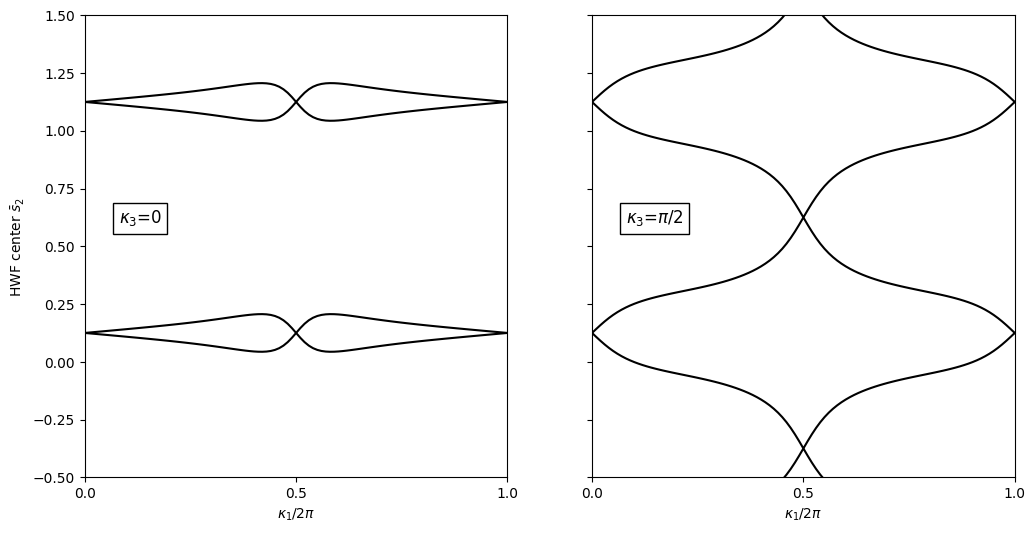

In [ ]:
# initialize plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for j in range(2):
  ax[j].set_xlim([0, 1])
  ax[j].set_xticks([0, 1/2, 1])
  ax[j].set_xlabel(r"$\kappa_1/2\pi$")
  ax[j].set_ylim(-0.5, 1.5)
  ax[j].text(0.08, 0.60, labs[j], size=12, bbox=dict(facecolor='w', edgecolor='k'))

  for n in range(2):
    for shift in [-1, 0, 1]:
      ax[j].plot(np.linspace(0, 1, nk), hwfc[:, j, n]+shift, color='k')

ax[0].set_ylabel(r"HWF center $\bar{s}_2$")

Text(0, 0.5, 'HWF center $\\bar{s}_2$')

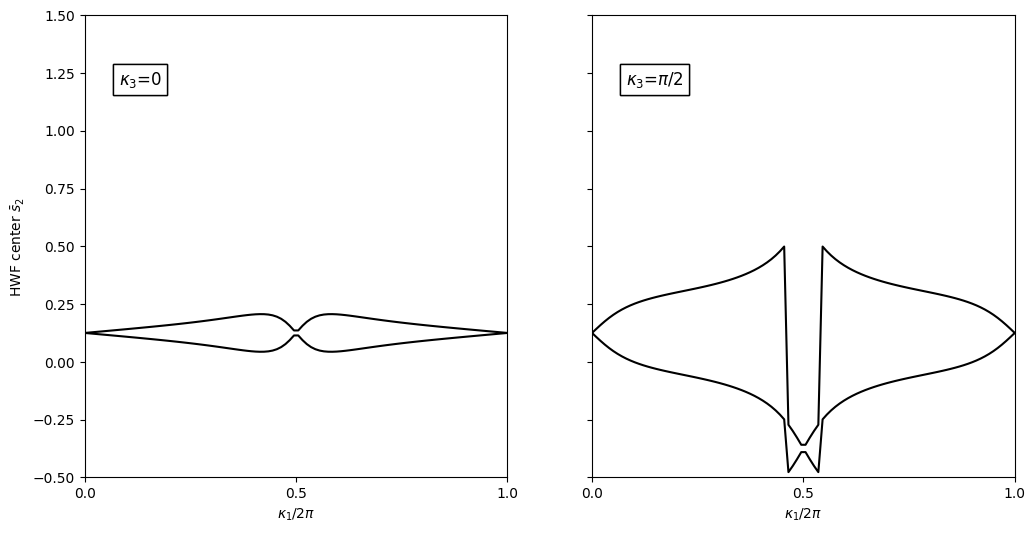

In [42]:
# initialize plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for j in range(2):
  ax[j].set_xlim([0, 1])
  ax[j].set_xticks([0, 1/2, 1])
  ax[j].set_xlabel(r"$\kappa_1/2\pi$")
  ax[j].set_ylim(-0.5, 1.5)

  for n in range(2):
    # for shift in [-1, 0, 1]:
    for shift in [0]:

      ax[j].plot(np.linspace(0, 1, nk), hwfc[:, j, n]+shift, color='k')

    ax[j].text(0.08,1.20,labs[j],size=12.,bbox=dict(facecolor='w',edgecolor='k'))

ax[0].set_ylabel(r"HWF center $\bar{s}_2$")